In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numpy.linalg import matrix_rank
import control

In [27]:
##### Model parameters
g = 9.81

w = 0.221
c = 0.0237
lambda_ = np.pi / 6

r_R = 0.041
m_R = 0.0346
I_R_xx = 2.10368e-05
I_R_yy = 4.07761e-05

x_B = 0.0768
z_B = -0.1005
m_B = 0.6824
I_B_xx = 0.0012
I_B_xz = 6.519389010215833e-04
I_B_yy = 0.0021
I_B_zz = 0.0019

x_H = 0.207
z_H = -0.09
m_H = 0.016
I_H_xx = 1.263e-05
I_H_xz = -3.866630222816761e-06
I_H_yy = 1.41456e-05
I_H_zz = 8.1652e-06

r_F = 0.041
m_F = 0.031
I_F_xx = 1.910940833333334e-05
I_F_yy = 3.662645e-05

In [28]:
##### Computations
cos_l = np.cos(lambda_)
sin_l = np.sin(lambda_)

m_T = m_R + m_B + m_H + m_F
x_T = (x_B*m_B + x_H*m_H + w*m_F) / m_T
z_T = (-r_R*m_R + z_B*m_B + z_H*m_H - r_F*m_F) / m_T

I_T_xx = I_R_xx + I_B_xx + I_H_xx + I_F_xx + m_R*r_R**2 + m_B*z_B**2+m_H*z_H**2+m_F*r_F**2
I_T_xz = I_B_xz + I_H_xz - m_B*x_B*z_B - m_H*x_H*z_H + m_F*w*r_F

I_R_zz = I_R_xx
I_F_zz = I_F_xx

I_T_zz = I_R_zz + I_B_zz + I_H_zz + I_F_zz + m_B*x_B**2 + m_H*x_H**2 + m_F*w**2

m_A = m_H + m_F
x_A = (x_H*m_H + w*m_F)/m_A
z_A = (z_H*m_H - r_F*m_F)/m_A

I_A_xx = I_H_xx + I_F_xx + m_H*(z_H - z_A)**2 + m_F*(r_F + z_A)**2
I_A_xz = I_H_xz - m_H*(x_H - x_A)*(z_H - z_A) + m_F*(w - x_A)*(r_F + z_A)
I_A_zz = I_H_zz + I_F_zz + m_H*(x_H - x_A)**2 + m_F*(w - x_A)**2

u_A = (x_A - w - c)*cos_l - z_A*sin_l

I_A_lambdalambda = m_A*u_A**2 + I_A_xx*sin_l**2 + 2*I_A_xz*sin_l*cos_l + I_A_zz*cos_l**2
I_A_lambdax = -m_A*u_A*z_A + I_A_xx*sin_l + I_A_xz*cos_l
I_A_lambdaz = m_A*u_A*x_A + I_A_xz*sin_l + I_A_zz*cos_l

mu = c/w*cos_l

S_R = I_R_yy / r_R
S_F = I_F_yy / r_F
S_T = S_R + S_F

S_A = m_A*u_A + mu*m_T*x_T

M_phiphi = I_T_xx
# print(M_phiphi)
M_phidelta = I_A_lambdax + mu*I_T_xz
# print(M_phidelta)
M_deltadelta = I_A_lambdalambda + 2*mu*I_A_lambdaz + mu**2*I_T_zz
# print(M_deltadelta)

K_0_phiphi = m_T*z_T
# print(K_0_phiphi)
K_0_phidelta = -S_A
# print(K_0_phidelta)
K_0_deltadelta = -S_A*sin_l
# print(K_0_deltadelta)

K_2_phidelta = (S_T - m_T*z_T)/w*cos_l
# print(K_2_phidelta)
K_2_deltadelta = (S_A + S_F*sin_l)/w*cos_l
# print(K_2_deltadelta)

C_1_phidelta = mu*S_T + S_F*cos_l + I_T_xz/w*cos_l - mu*m_T*z_T
# print(C_1_phidelta)
C_1_deltaphi = -(mu*S_T + S_F*cos_l)
# print(C_1_deltaphi)
C_1_deltadelta = I_A_lambdaz/w*cos_l + mu*(S_A + I_T_zz/w*cos_l)
# print(C_1_deltadelta)

##### Assemble output
M = np.array([[M_phiphi, M_phidelta],
              [M_phidelta, M_deltadelta]])
K_0 = np.array([[K_0_phiphi, K_0_phidelta],
                [K_0_phidelta, K_0_deltadelta]])
K_2 = np.array([[0, K_2_phidelta],
                [0, K_2_deltadelta]])
C_1 = np.array([[0, C_1_phidelta],
                [C_1_deltaphi, C_1_deltadelta]])
print(M)
print(K_0)
print(K_2)
print(C_1)

[[ 0.00838506  0.0006334 ]
 [ 0.0006334   0.00010957]]
[[-0.0727108  -0.00600799]
 [-0.00600799 -0.003004  ]]
[[ 0.          0.29232733]
 [ 0.          0.02529365]]
[[ 0.          0.03314994]
 [-0.00094898  0.00377701]]


In [29]:
#funtion to compute the eigenvalues of uncontrolled bike
def eig_values(M, C1, K0, K2, v):
    #gravity
    g = 9.81
    
    #compute C and K matrix
    C = v*C1
    K = g*K0 + (v**2)*K2
    
    #Get the coefficients for each order
    fourth_order = M[0][0]*M[1][1] - M[0][1]*M[1][0]
    
    third_order = M[0][0]*C[1][1] + C[0][0]*M[1][1]\
                - M[0][1]*C[1][0] - C[0][1]*M[1][0]
        
    second_order = M[0][0]*K[1][1] + C[0][0]*C[1][1] + K[0][0]*M[1][1]\
                 - M[0][1]*K[1][0] - C[0][1]*C[1][0] - K[0][1]*M[1][0]
    
    first_order = C[0][0]*K[1][1] + K[0][0]*C[1][1]\
                - C[0][1]*K[1][0] - K[0][1]*C[1][0]
        
    constant = K[0][0]*K[1][1] - K[0][1]*K[1][0]
    
    #compute the eigenvalues
    coeff = [fourth_order, third_order, second_order, first_order, constant]
    eigs = np.roots(coeff)
    
    return eigs

Capsize pole becomes unstable at v = : 4.647 m/s
Weave poles becomes stable at v = : 2.672 m/s
Self stable region from 2.672 to 4.647


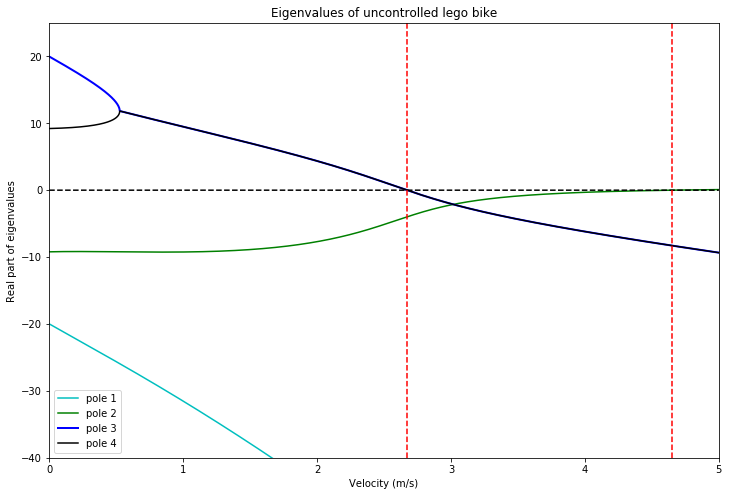

In [33]:
v = np.linspace(0.0, 5.0, 5000)
eigs = np.zeros((5000,4), dtype=complex)
zero = np.zeros(5000)

for i in range(0, 5000):
    eigs[i] = eig_values(M,C_1, K_0, K_2, v[i])

real_eigs = eigs.real

#Adjust the position of values so that each pole become continuous
#Don't know why does this happen, maybe because of the roots function
tmp = np.array(real_eigs[0:94, 1])
real_eigs[0:94, 1] = real_eigs[0:94, 2]
real_eigs[0:94, 2] = tmp
tmp = np.array(real_eigs[1053:, 1])
real_eigs[1053:, 1] = real_eigs[1053:, 3]
real_eigs[1053:, 3] = tmp

#Velocity when capsize pole become unstable
for i in range(0, 5000):
    if(real_eigs[i, 1]>0):
        v_capsize = i/1000.0
        print("Capsize pole becomes unstable at v = :", v_capsize, "m/s")
        break; 
        
#Velocity when weave poles become stable
for i in range(0, 5000):
    if(real_eigs[i, 3]<0):
        v_weave = i/1000.0
        print("Weave poles becomes stable at v = :", v_weave, "m/s")
        break; 
        
print("Self stable region from", v_weave, "to", v_capsize)

#print(real_eigs[1000:1100, :])
plt.figure(figsize=(12, 8))
plt.plot(v, real_eigs[:, 0], 'c', label = 'pole 1')
plt.plot(v, real_eigs[:, 1], 'g', label = 'pole 2')
plt.plot(v, real_eigs[:, 2], 'b', label = 'pole 3', linewidth = 2.0)
plt.plot(v, real_eigs[:, 3], 'k', label = 'pole 4')
plt.plot(v, zero, 'k', linestyle='dashed')
plt.axvline(x = v_weave, color = 'r', linestyle='dashed')
plt.axvline(x = v_capsize, color = 'r', linestyle='dashed')
plt.xlim([0.0, 5.0])
plt.ylim([-40.0, 25.0])
plt.title("Eigenvalues of uncontrolled lego bike")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Real part of eigenvalues")
plt.legend()
plt.show()

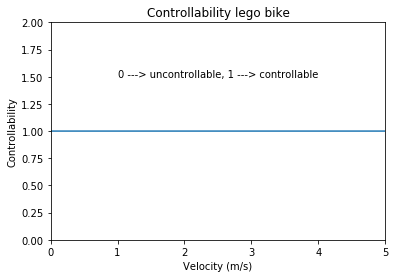

In [42]:
#Controllability check
Minv = np.linalg.inv(M)
MinvOne = Minv @ np.array([[0],[1]])
B = np.array([[0], [0], [MinvOne[0]], [MinvOne[1]]])

def get_KandC(C1, K0, K2, v):
    C = v*C1
    K = g*K0 + v**2*K2
    
    return (C, K)

def get_A(C, K):
    negMinvK = -Minv @ K
    negMinvC = -Minv @ C

    A = np.array([[0,   0,      1,  0],\
                  [0,   0,      0,  1],\
                  [negMinvK[0,0], negMinvK[0,1],    negMinvC[0,0], negMinvC[0,1]],\
                  [negMinvK[1,0], negMinvK[1,1],    negMinvC[1,0], negMinvC[1,1]]])

    return A


controllable = np.zeros(5000)
Q = np.array([[7,0,0,0], [0,1,0,0], [0,0,10,0],[0,0,0,1]])
R = 1
K = np.zeros(5000)

for i in range(0, 5000):
    mats = get_KandC(C_1, K_0, K_2, v[i])
    C, K = mats
    A = get_A(C, K)
    tmp = control.ctrb(A, B)
    #K[i] = control.lqr(A,B,Q,R)
    rank = matrix_rank(tmp)
    if rank == 4:
        controllable[i] = 1


        
plt.figure
plt.plot(v, controllable)
plt.xlim([0.0, 5.0])
plt.ylim([0.0, 2.0])
plt.title("Controllability lego bike")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Controllability")
plt.text(1.0 , 1.5, "0 ---> uncontrollable, 1 ---> controllable")
plt.legend()
plt.show()
